A notebook for capturing calibration data for the cameras of the OROCHI Simualtor of the Kameda Lab.

Fourth round of experiments after procedure upgrade adding 8th camera, and switching some camera positions.

Using a gain of 4.27 dB to raise apparent full well to 20000 e-, and sensitivity to 4.88 e-/DN.
Reducing Blacklevel to 8 DN from 128 DN, to increase sensitive range.

# Process Overview

The objective of this notebook is to capture uniformly illuminated and dark images (across the sampling area) that can be used to characterise each camera of the OROCHI simulator, in terms of:
- Linearity
- Read Noise
- Gain
- FPN
- Dark Signal

To do this, we will  capture images of the 99% Reflectance Spectralon Calibration Target (SCT99) and the 5% Reflectance Spectral Calibration Target (SCT5), and images without illumination, at exposures that range from the minimum possible with the cameras (~5 µs) up to a maximum, defined such that all pixels of the image are saturated (DN=255).

For each exposure, we will capture:
- 2 illuminated images of the target
- 25 dark images (to reduce read noise by factor of 5)

We will choose exposures with the following procedure:
1. Start at minimum exposure - capture pair, record exposure
2. Double exposure - capture pair, record exposure
3. Repeat until all pixels are saturated - i.e. all = 255
4. Reduce exposure by factor of 0.90, and repeat, until 0 pixels are saturated.

This process will be repeated for SCT99 and SCT5, and then again for dark images.
Then, 25 dark frames will be captured for each exposure, and the mean and standard deviation TIFF float images recorded.


# Camera Setup

Here we configure and setup the camera capture objects.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import orochi_sim_ctrl as osc

ic = osc.start_ic()
camera_config = osc.load_camera_config()
cameras = osc.connect_cameras(ic, camera_config)
osc.configure_cameras(cameras)

Device 0 (DMK 33GX249 10910288) succesfully connected.
Device 1 (DMK 33GX249 10910273) succesfully connected.
Device 2 (DMK 33GX249 10910289) succesfully connected.
Device 3 (DMK 33GX249 10910294) succesfully connected.
Device 4 (DMK 33GX249 10910291) succesfully connected.
Device 5 (DMK 33GX249 10910295) succesfully connected.
Device 7 (DMK 33GX249 23120778) succesfully connected.
Device 6 (DMK 33GX249 10910265) succesfully connected.
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
1
Sink Format set to : "SinkFormats.Y16"
Frame Rate set to : 1.0 FPS
Brightness Value set to 0
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 4.269999980926514
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 10.0
Exposure Auto Max Auto set to 0
Trigger Enable set to 0
De

In [3]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from time import sleep

Here we are only going to process images over the calibration target itself, so we restrict the ROI to a very small field of 32x32 pixels.
Statistics are therfore computed over 1024 pixels in each case.

-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 235.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.16550213098526
Exposure set to 0.16550199687480927 (err of 1.386456944529879e-07
Trial 1:
Imaging with Exposure: 0.16550199687480927 s
+Good exposure 0.16550199687480927 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.16550199687480927
Exposure Value set to 0.03144538030028343
Exposure set to 0.03144500032067299 (err of 3.790855407706517e-07
Trial 2:
Imaging with Exposure: 0.03144500032067299 s
+Good exposure 0.03144500032067299 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.03144500032067299
Exposure Valu

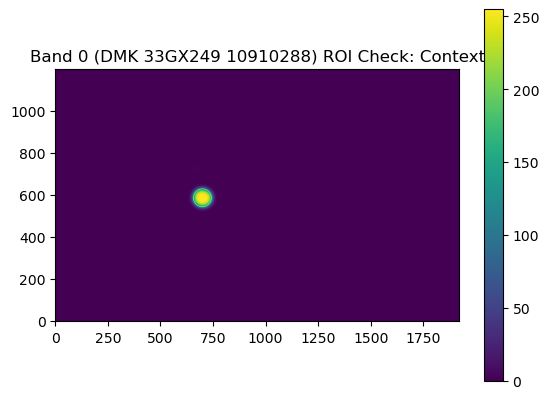

Imaging with Exposure: 0.026979999616742134 s
+Good exposure 0.026979999616742134 Image recieved


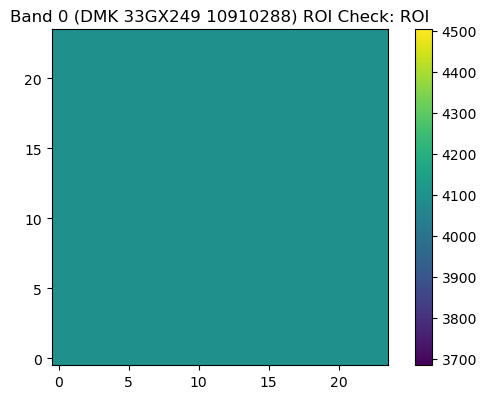

-----------------------------------
-----------------------------------
Device 1 (DMK 33GX249 10910273)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 324.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.12004012614488602
Exposure set to 0.12003999948501587 (err of 1.2967337417735258e-07
Trial 1:
Imaging with Exposure: 0.12003999948501587 s
+Good exposure 0.12003999948501587 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.12003999948501587
Exposure Value set to 0.02280759997665882
Exposure set to 0.02280700020492077 (err of 5.996972322445948e-07
Trial 2:
Imaging with Exposure: 0.02280700020492077 s
+Good exposure 0.02280700020492077 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current 

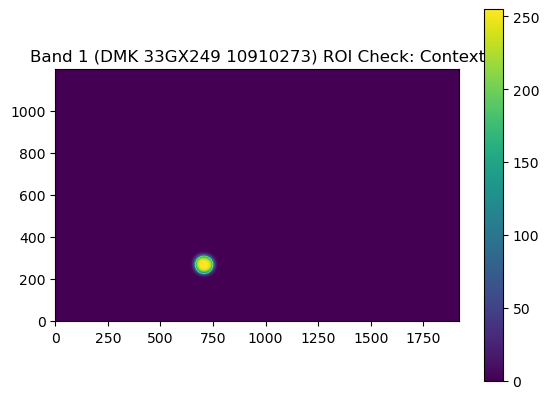

Imaging with Exposure: 0.019334999844431877 s
+Good exposure 0.019334999844431877 Image recieved


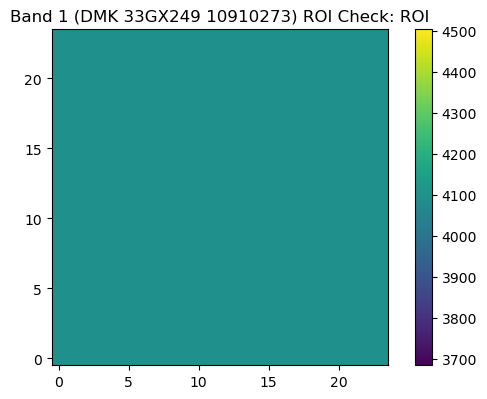

-----------------------------------
-----------------------------------
Device 2 (DMK 33GX249 10910289)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 1195.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.0065092891454696655
Exposure set to 0.006508999969810247 (err of 2.890422932449663e-07
Trial 1:
Imaging with Exposure: 0.006508999969810247 s
+Good exposure 0.006508999969810247 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.006508999969810247
Exposure Value set to 0.0012367099989205599
Exposure set to 0.0012359999818727374 (err of 7.100123912094896e-07
Trial 2:
Imaging with Exposure: 0.0012359999818727374 s
+Good exposure 0.0012359999818727374 Image recieved
Quantile: 602.0, Target: 3889.2999999999997
Expo

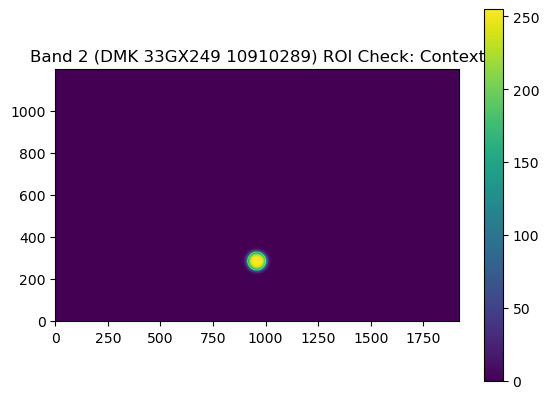

Imaging with Exposure: 0.007404999807476997 s
+Good exposure 0.007404999807476997 Image recieved


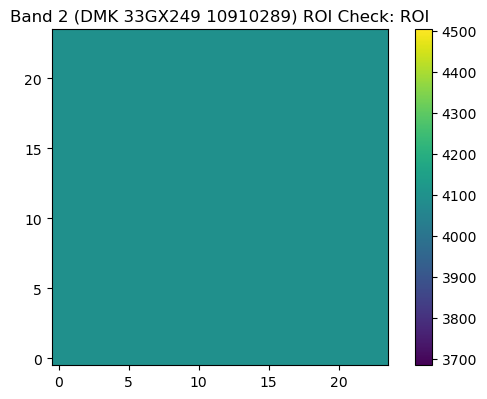

-----------------------------------
-----------------------------------
Device 3 (DMK 33GX249 10910294)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 161.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.24157144129276276
Exposure set to 0.24157099425792694 (err of 4.457875287522395e-07
Trial 1:
Imaging with Exposure: 0.24157099425792694 s
+Good exposure 0.24157099425792694 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.24157099425792694
Exposure Value set to 0.04589848965406418
Exposure set to 0.04589800164103508 (err of 4.87267971034655e-07
Trial 2:
Imaging with Exposure: 0.04589800164103508 s
+Good exposure 0.04589800164103508 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Va

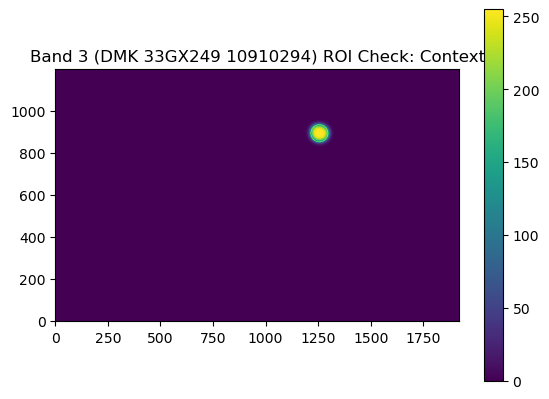

Imaging with Exposure: 0.039344001561403275 s
+Good exposure 0.039344001561403275 Image recieved


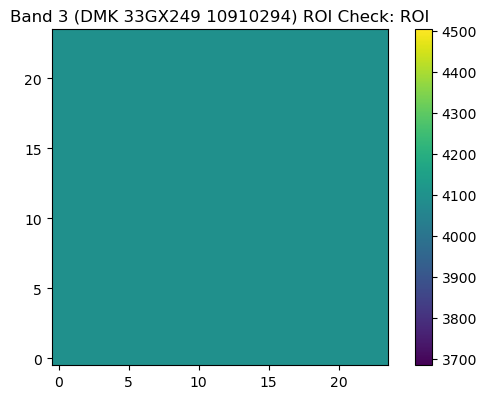

-----------------------------------
-----------------------------------
Device 4 (DMK 33GX249 10910291)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 634.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.012269086204469204
Exposure set to 0.012268999591469765 (err of 8.616478208711698e-08
Trial 1:
Imaging with Exposure: 0.012268999591469765 s
+Good exposure 0.012268999591469765 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.012268999591469765
Exposure Value set to 0.0023311099503189325
Exposure set to 0.002331000054255128 (err of 1.0986812412714514e-07
Trial 2:
Imaging with Exposure: 0.002331000054255128 s
+Good exposure 0.002331000054255128 Image recieved
Quantile: 632.0, Target: 3889.2999999999997
Exposure

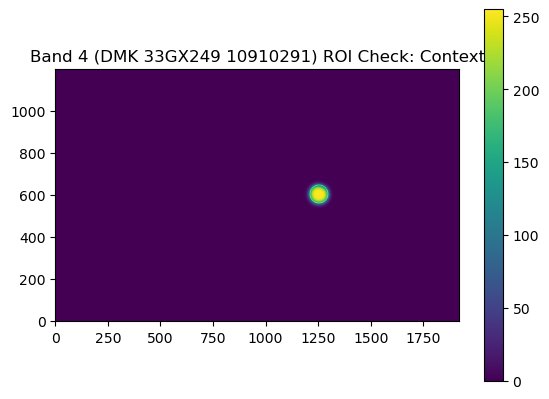

Imaging with Exposure: 0.010254000313580036 s
+Good exposure 0.010254000313580036 Image recieved


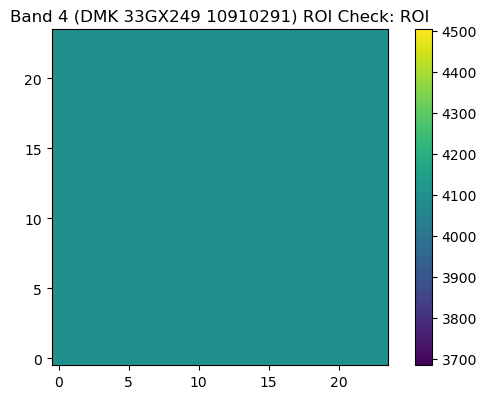

-----------------------------------
-----------------------------------
Device 5 (DMK 33GX249 10910295)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 559.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.01391520630568266
Exposure set to 0.013914999552071095 (err of 2.0683337375974886e-07
Trial 1:
Imaging with Exposure: 0.013914999552071095 s
+Good exposure 0.013914999552071095 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.013914999552071095
Exposure Value set to 0.0026438499335199594
Exposure set to 0.002643000101670623 (err of 8.498132228846808e-07
Trial 2:
Imaging with Exposure: 0.002643000101670623 s
+Good exposure 0.002643000101670623 Image recieved
Quantile: 836.0, Target: 3889.2999999999997
Exposure 

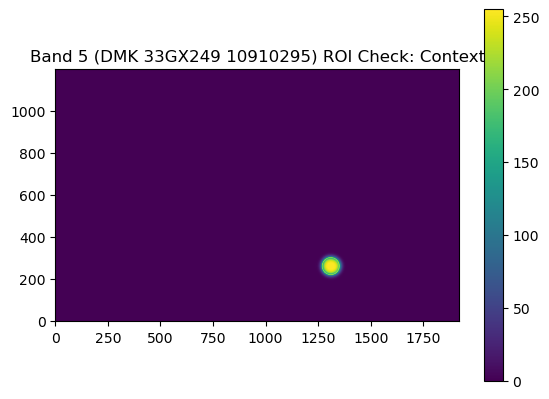

Imaging with Exposure: 0.012683999724686146 s
+Good exposure 0.012683999724686146 Image recieved


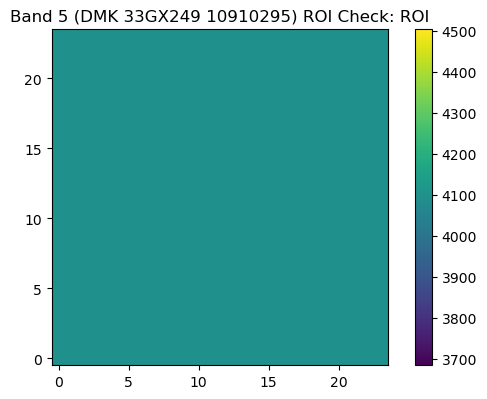

-----------------------------------
-----------------------------------
Device 7 (DMK 33GX249 23120778)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 1289.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.0060346005484461784
Exposure set to 0.0060339998453855515 (err of 6.009067197044332e-07
Trial 1:
Imaging with Exposure: 0.0060339998453855515 s
+Good exposure 0.0060339998453855515 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.0060339998453855515
Exposure Value set to 0.0011464599519968033
Exposure set to 0.001145999995060265 (err of 4.5997556298951227e-07
Trial 2:
Imaging with Exposure: 0.001145999995060265 s
+Good exposure 0.001145999995060265 Image recieved
Quantile: 651.0, Target: 3889.2999999999997
Ex

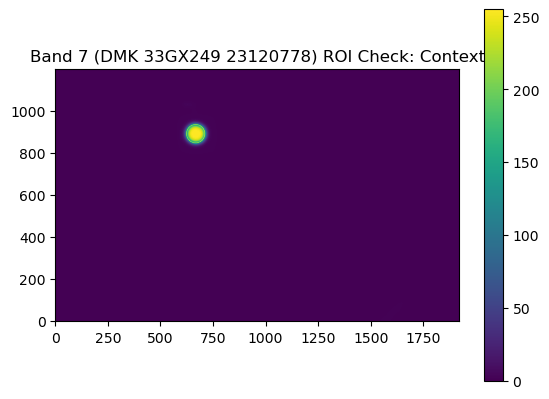

Imaging with Exposure: 0.021716000512242317 s
+Good exposure 0.021716000512242317 Image recieved


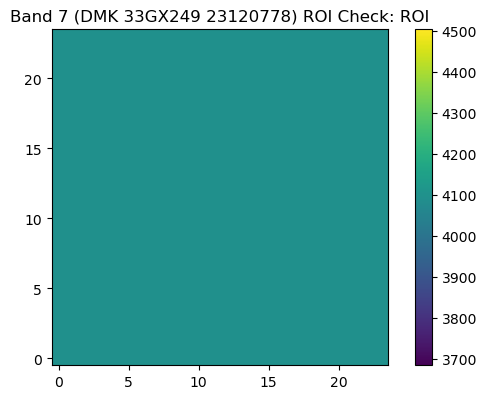

-----------------------------------
-----------------------------------
Device 6 (DMK 33GX249 10910265)
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 118.0, Target: 3889.2999999999997
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.3296017050743103
Exposure set to 0.329600989818573 (err of 7.207519216456681e-07
Trial 1:
Imaging with Exposure: 0.329600989818573 s
+Good exposure 0.329600989818573 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.329600989818573
Exposure Value set to 0.06262418627738953
Exposure set to 0.0626240000128746 (err of 1.8805265425414497e-07
Trial 2:
Imaging with Exposure: 0.0626240000128746 s
+Good exposure 0.0626240000128746 Image recieved
Quantile: 4094.0, Target: 3889.2999999999997
Exposure current Value: 0.062

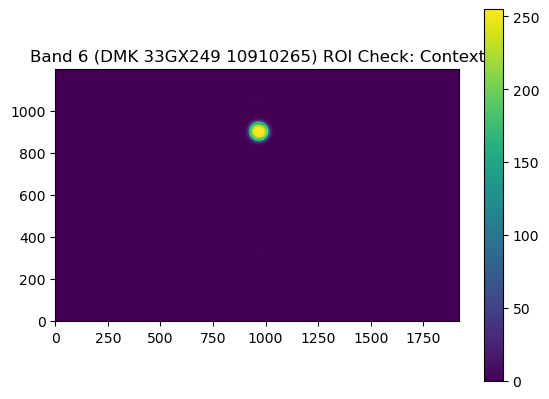

Imaging with Exposure: 0.05450500175356865 s
+Good exposure 0.05450500175356865 Image recieved


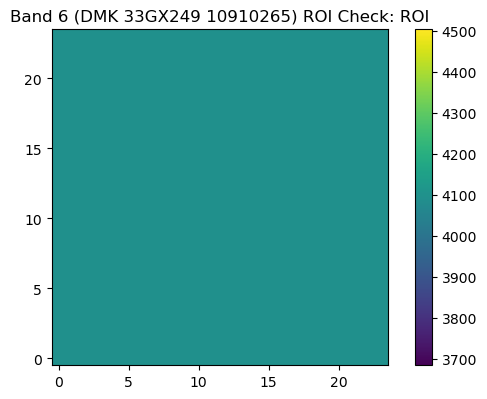

-----------------------------------


In [4]:
osc.find_camera_rois(cameras, roi_size=24)

-----------------------------------
Device 0
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 377.0, Target: 3275.2000000000003
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.08687533438205719
Exposure set to 0.08687499910593033 (err of 3.365854132353352e-07
Trial 1:
Imaging with Exposure: 0.08687499910593033 s
+Good exposure 0.08687499910593033 Image recieved
Quantile: 4094.0, Target: 3275.2000000000003
Exposure current Value: 0.08687499910593033
Exposure Value set to 0.013899999670684338
Exposure set to 0.013899000361561775 (err of 9.994953870783724e-07
Trial 2:
Imaging with Exposure: 0.013899000361561775 s
+Good exposure 0.013899000361561775 Image recieved
Quantile: 3020.0, Target: 3275.2000000000003
Exposure current Value: 0.013899000361561775
Exposure Value set to 0.0150

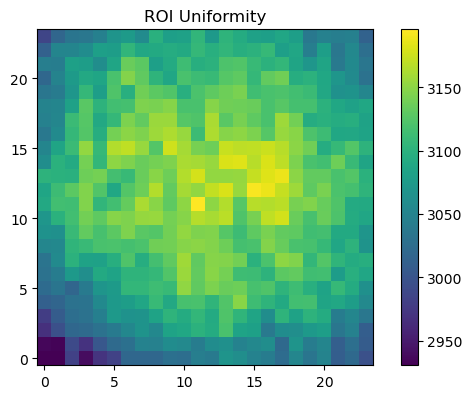

ROI Uniformity: 1.500992517505002 %
-----------------------------------
-----------------------------------
Device 1
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 583.0, Target: 3275.2000000000003
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.011235677637159824
Exposure set to 0.011234999634325504 (err of 6.784293576939798e-07
Trial 1:
Imaging with Exposure: 0.011234999634325504 s
+Good exposure 0.011234999634325504 Image recieved
Quantile: 3920.0, Target: 3275.2000000000003
Exposure current Value: 0.011234999634325504
Exposure Value set to 0.009386956691741943
Exposure set to 0.009386000223457813 (err of 9.566138745569636e-07
Trial 2:
Imaging with Exposure: 0.009386000223457813 s
+Good exposure 0.009386000223457813 Image recieved
Quantile: 3095.0, Target: 3275.2000000000

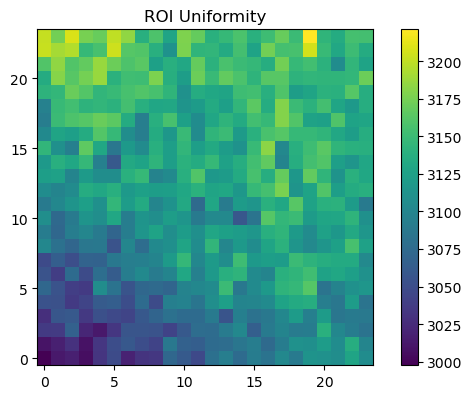

ROI Uniformity: 1.2230795733123863 %
-----------------------------------
-----------------------------------
Device 2
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 1860.0, Target: 3275.2000000000003
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.0035217206459492445
Exposure set to 0.0035210000351071358 (err of 7.20562273136098e-07
Trial 1:
Imaging with Exposure: 0.0035210000351071358 s
+Good exposure 0.0035210000351071358 Image recieved
Quantile: 3642.0, Target: 3275.2000000000003
Exposure current Value: 0.0035210000351071358
Exposure Value set to 0.003166386391967535
Exposure set to 0.0031659998930990696 (err of 3.865195815706997e-07
Trial 2:
Imaging with Exposure: 0.0031659998930990696 s
+Good exposure 0.0031659998930990696 Image recieved
Quantile: 3645.0, Target: 3275.2

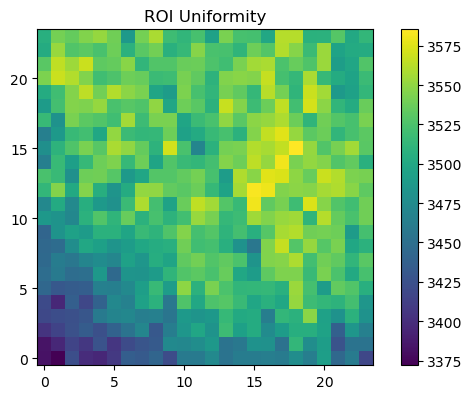

ROI Uniformity: 1.1130798442128154 %
-----------------------------------
-----------------------------------
Device 3
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 370.0, Target: 3275.2000000000003
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.08851892501115799
Exposure set to 0.08851800113916397 (err of 9.219841780039317e-07
Trial 1:
Imaging with Exposure: 0.08851800113916397 s
+Good exposure 0.08851800113916397 Image recieved
Quantile: 4094.0, Target: 3275.2000000000003
Exposure current Value: 0.08851800113916397
Exposure Value set to 0.01416288036853075
Exposure set to 0.014162000268697739 (err of 8.79913568497398e-07
Trial 2:
Imaging with Exposure: 0.014162000268697739 s
+Good exposure 0.014162000268697739 Image recieved
Quantile: 3138.0, Target: 3275.2000000000003
Ex

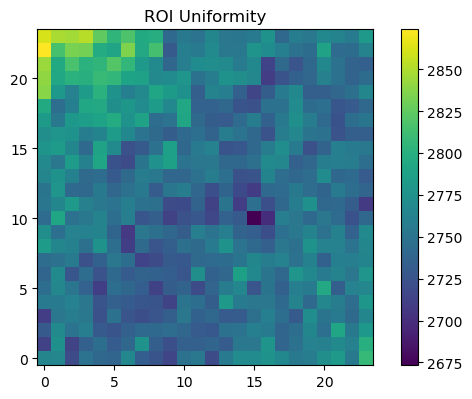

ROI Uniformity: 0.9066841256227269 %
-----------------------------------
-----------------------------------
Device 4
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 922.0, Target: 3275.2000000000003
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.007104555610567331
Exposure set to 0.007104000076651573 (err of 5.555753303208844e-07
Trial 1:
Imaging with Exposure: 0.007104000076651573 s
+Good exposure 0.007104000076651573 Image recieved
Quantile: 3975.0, Target: 3275.2000000000003
Exposure current Value: 0.007104000076651573
Exposure Value set to 0.00585333863273263
Exposure set to 0.005853000096976757 (err of 3.3853221801868894e-07
Trial 2:
Imaging with Exposure: 0.005853000096976757 s
+Good exposure 0.005853000096976757 Image recieved
Quantile: 3118.0, Target: 3275.200000000

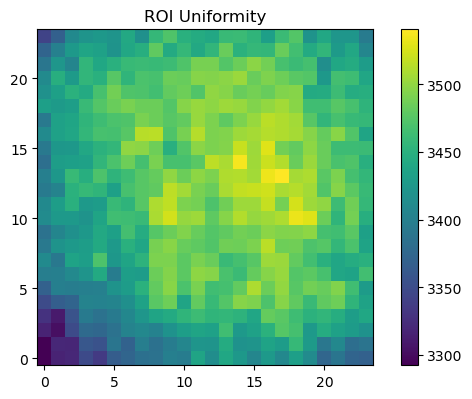

ROI Uniformity: 1.23410296031247 %
-----------------------------------
-----------------------------------
Device 5
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 862.0, Target: 3275.2000000000003
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.007599072065204382
Exposure set to 0.007598999887704849 (err of 7.239898576049536e-08
Trial 1:
Imaging with Exposure: 0.007598999887704849 s
+Good exposure 0.007598999887704849 Image recieved
Quantile: 3765.0, Target: 3275.2000000000003
Exposure current Value: 0.007598999887704849
Exposure Value set to 0.00661042332649231
Exposure set to 0.006610000040382147 (err of 4.2344758888201994e-07
Trial 2:
Imaging with Exposure: 0.006610000040382147 s
+Good exposure 0.006610000040382147 Image recieved
Quantile: 3352.0, Target: 3275.20000000000

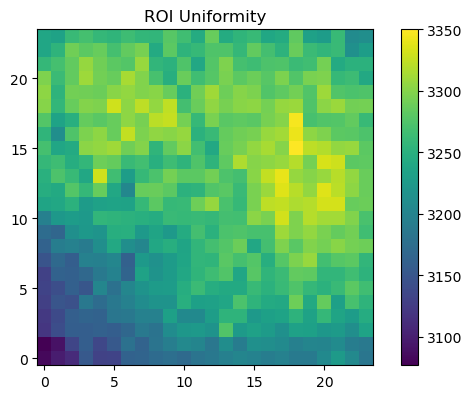

ROI Uniformity: 1.4849501996282142 %
-----------------------------------
-----------------------------------
Device 7
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 2031.0, Target: 3275.2000000000003
Exposure current Value: 0.04149999842047691
Exposure Value set to 0.06692308932542801
Exposure set to 0.06692299991846085 (err of 8.960726342877035e-08
Trial 1:
Imaging with Exposure: 0.06692299991846085 s
+Good exposure 0.06692299991846085 Image recieved
Quantile: 4094.0, Target: 3275.2000000000003
Exposure current Value: 0.06692299991846085
Exposure Value set to 0.010707680135965347
Exposure set to 0.010707000270485878 (err of 6.797164678572221e-07
Trial 2:
Imaging with Exposure: 0.010707000270485878 s
+Good exposure 0.010707000270485878 Image recieved
Quantile: 4094.0, Target: 3275.2000000000003
E

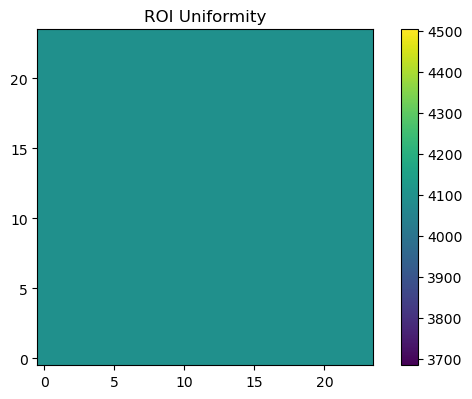

ROI Uniformity: 0.0 %
-----------------------------------
-----------------------------------
Device 6
-----------------------------------
Initiating search:
Exposure Auto set to 0
Exposure Value set to 0.0020000000949949026
Trial 0:
Imaging with Exposure: 0.0020000000949949026 s
+Good exposure 0.0020000000949949026 Image recieved
Quantile: 277.0, Target: 3275.2000000000003
Exposure current Value: 0.0020000000949949026
Exposure Value set to 0.11823827028274536
Exposure set to 0.11823800206184387 (err of 2.707021869163828e-07
Trial 1:
Imaging with Exposure: 0.11823800206184387 s
+Good exposure 0.11823800206184387 Image recieved
Quantile: 4094.0, Target: 3275.2000000000003
Exposure current Value: 0.11823800206184387
Exposure Value set to 0.018918080255389214
Exposure set to 0.018918000161647797 (err of 8.01682472247045e-08
Trial 2:
Imaging with Exposure: 0.018918000161647797 s
+Good exposure 0.018918000161647797 Image recieved
Quantile: 2057.0, Target: 3275.2000000000003
Exposure current

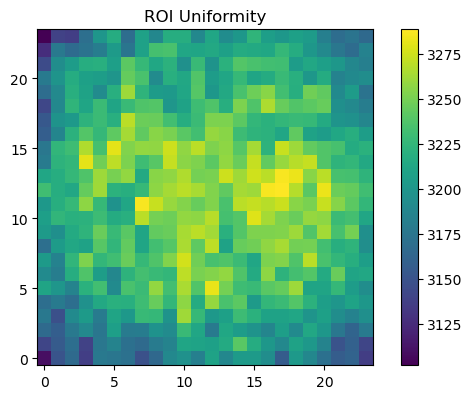

ROI Uniformity: 0.9911868908566612 %
-----------------------------------


In [5]:
osc.check_channel_roi_uniformity(cameras)

# Calibration Functions

Here we define simple functions for controlling the cameras during the calibration routines.

In [6]:
def camera_calibration_sequence(camera, subject) -> pd.DataFrame:
    """Capture pairs of images with increasing exposure time until all
    pixels are saturated, then decrease exposure time until no pixels are 
    saturated.
    
    Args:
        camera: Camera object to capture images from.
    
    Returns:
        DataFrame with columns:
            - exposure
            - mean
            - std
    """
    camera.set_property('Exposure', 'Auto', 0, 'Switch')        
    t_min = 1.0/16666 # (seconds) verify that this is the minimum exposure time
    t_max = 50.0
    t_exp = t_min
    up_scale = 1.2
    dwn_scale = 0.99
    t_scale = up_scale
    img_type='calibration'
    stop = False    
    cmd_exposures = []
    exposures = []
    means = []
    stds = []
    shots = []
    sat_val = camera.max_dn
    while stop is False:
        print(f'Exposure: {t_exp:.7f} s')
        camera.set_property('Exposure', 'Value', t_exp, 'AbsoluteValue')
        img_1 = camera.image_capture(roi=True)
        img_2 = camera.image_capture(roi=True)
        name_1 = f'{t_exp*1E6:.0f}us_1'
        name_2 = f'{t_exp*1E6:.0f}us_2'
        camera.save_image(name_1, subject, img_type, img_1)
        camera.save_image(name_2, subject, img_type, img_2)
        exposures.append(camera.get_exposure_value())
        cmd_exposures.append(t_exp)
        mean = np.mean([np.mean(img_1), np.mean(img_2)])
        std = np.mean([np.std(img_1), np.std(img_2)])
        shot = np.sqrt(np.mean((img_1 - img_2)**2)/2)
        means.append(mean)
        stds.append(std)
        shots.append(shot)
        if mean >= sat_val * 0.999:
            t_scale = dwn_scale
        if t_scale == dwn_scale:
            # n_sat = (np.sum(img_1 == sat_val) + np.sum(img_2 == sat_val)) / 2
            if mean <= sat_val * 0.80:
                stop = True
        else:
            if t_exp*t_scale > t_max:
                t_scale = dwn_scale
        t_exp = t_exp * t_scale

    results = pd.DataFrame({'exposure': exposures, 'raw mean': means, 'raw standard deviation': stds, 'shot and read noise': shots})
    results.sort_values('exposure', inplace=True)

    print(results)

    cwl_str = str(int(camera.camera_props['cwl']))
    channel = str(camera.camera_props['number'])+'_'+cwl_str
    subject_dir = Path('..', 'data', subject, channel)
    subject_dir.mkdir(parents=True, exist_ok=True)
    filename = 'exposures.csv'
    img_file =str(Path(subject_dir, filename).with_suffix('.tif'))

    results['exposure'].to_csv(f'{subject}_exposures.csv', index=False)

    fig, ax = plt.subplots(2,1, figsize=(5,10))
    ax[0].plot(results['exposure'], results['raw mean'])
    ax[0].set_xlabel('Exposure (s)')
    ax[0].set_ylabel('Mean Pixel Value')
    results.sort_values('raw mean', inplace=True)
    ax[1].loglog(results['raw mean'], results['raw standard deviation'], label='Total Noise')
    ax[1].loglog(results['raw mean'], results['shot and read noise'], label='Shot and Read Noise')
    ax[1].set_xlabel('Mean Pixel Value')
    ax[1].set_ylabel('Standard Deviation')
    plt.show()
    return cmd_exposures

# SCT99 Procedure

Output:
- SCT99 Exposure List
- SCT99 Lit Image Directory

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\0_850\850_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\0_850\850_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\SCT99_080623\0_850\850_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data

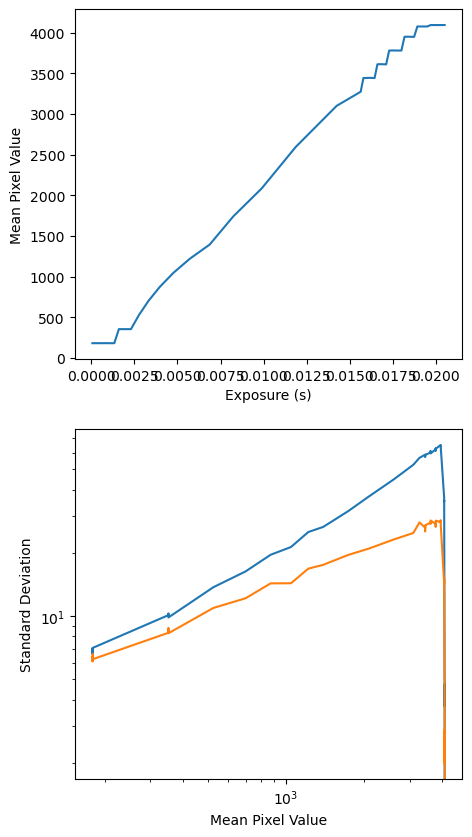

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\1_475\475_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\1_475\475_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\SCT99_080623\1_475\475_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data

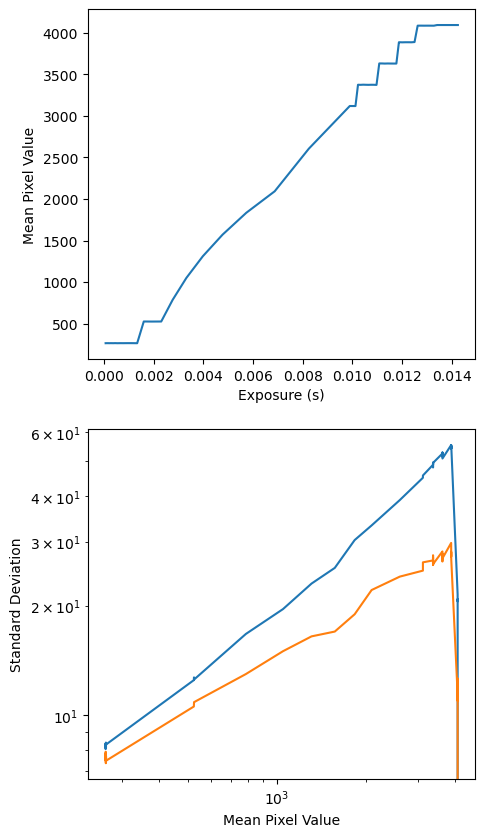

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\2_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\2_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\SCT99_080623\2_550\550_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data

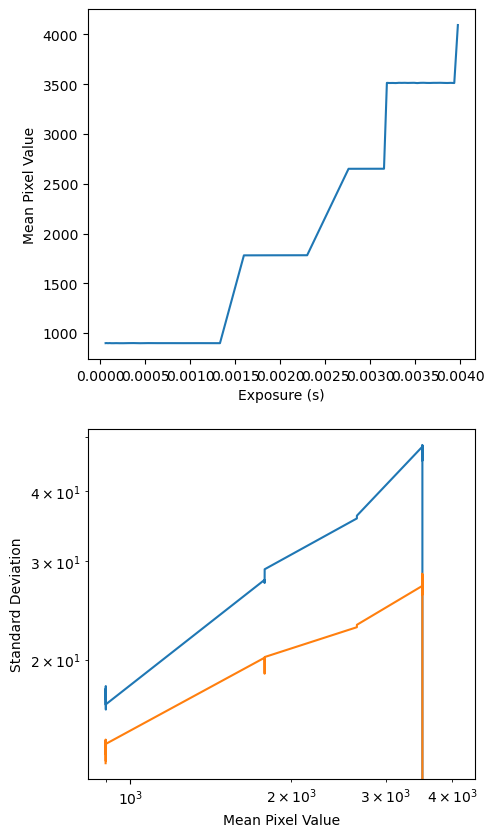

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\3_400\400_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\3_400\400_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\SCT99_080623\3_400\400_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data

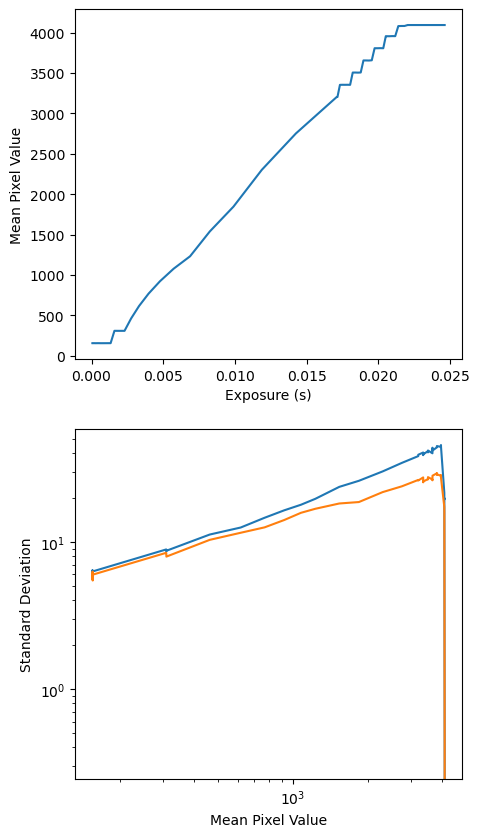

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\4_725\725_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\4_725\725_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\SCT99_080623\4_725\725_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data

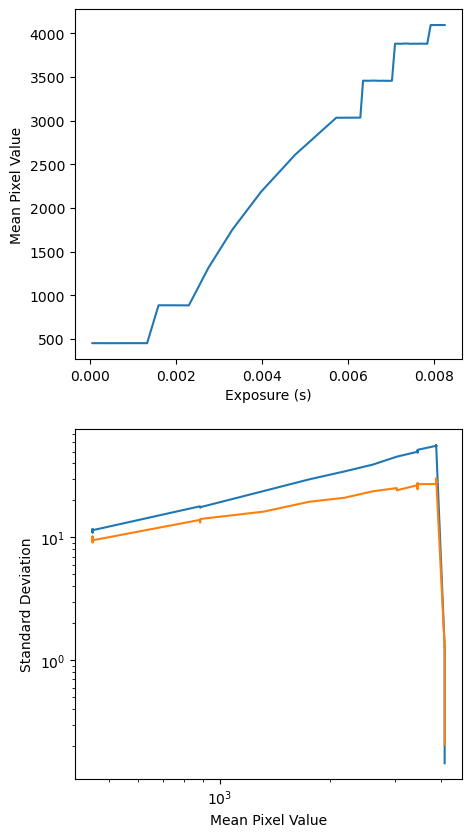

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\5_650\650_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\5_650\650_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\SCT99_080623\5_650\650_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data

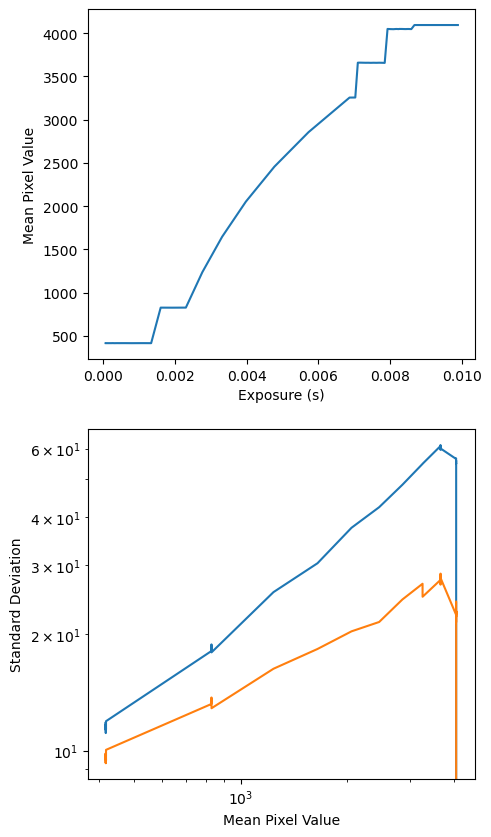

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\7_550\550_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\7_550\550_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 0.0014939999673515558 s
+Good exposure 0.0014939999673515558 Image recieved
Exposure current Value: 0.0014939999673515558
Image 72us_1 written to ..\data\SCT99_080623\7_550\550_72us_1_calibration.tif
Exposure current Value: 0.0014939999673515558
Image 72us_2 written to ..\data

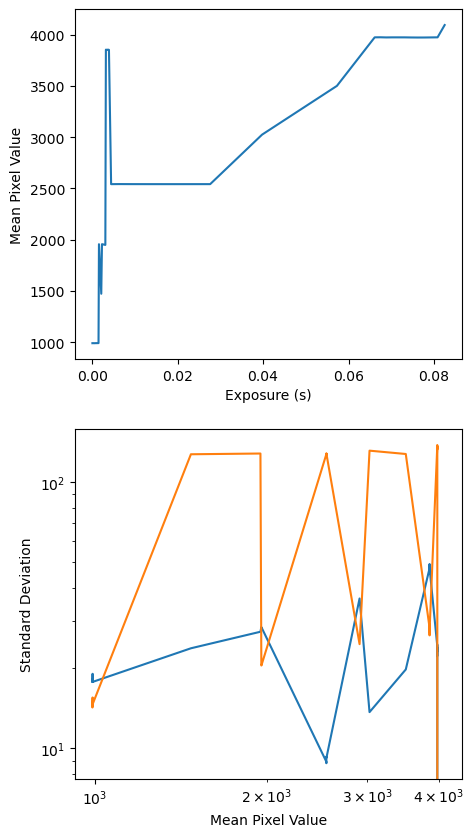

Exposure Auto set to 0
Exposure: 0.0000600 s
Exposure Value set to 6.000239955028519e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure current Value: 5.999999848427251e-05
Image 60us_1 written to ..\data\SCT99_080623\6_950\950_60us_1_calibration.tif
Exposure current Value: 5.999999848427251e-05
Image 60us_2 written to ..\data\SCT99_080623\6_950\950_60us_2_calibration.tif
Exposure: 0.0000720 s
Exposure Value set to 7.200287654995918e-05
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Imaging with Exposure: 7.200000254670158e-05 s
+Good exposure 7.200000254670158e-05 Image recieved
Exposure current Value: 7.200000254670158e-05
Image 72us_1 written to ..\data\SCT99_080623\6_950\950_72us_1_calibration.tif
Exposure current Value: 7.200000254670158e-05
Image 72us_2 written to ..\data

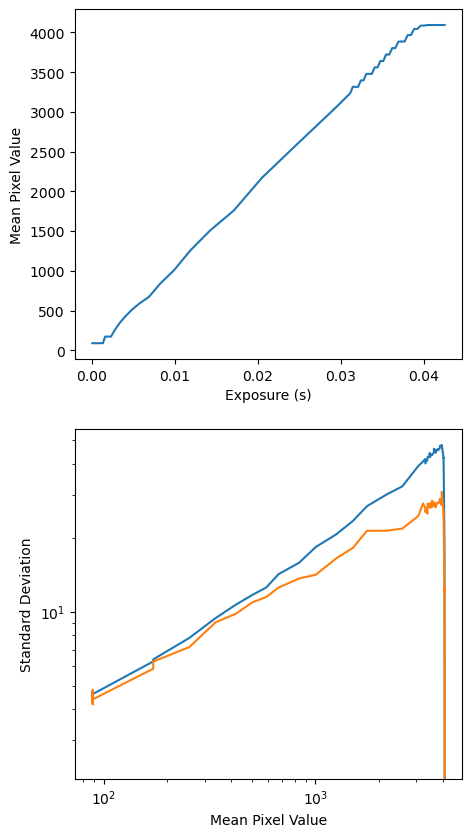

In [7]:
sct99_exposures = {}
for camera in cameras:
    sct99_exposures[camera] = camera_calibration_sequence(camera, 'SCT99_080623')

# SCT5 Procedure

Output:
- SCT5 Exposure List
- SCT5 Lit Image Directory

In [ ]:
osc.check_channel_roi_uniformity(cameras)

In [ ]:
sct5_exposures = {}
for camera in cameras:
    sct5_exposures[camera] = camera_calibration_sequence(camera, 'SCT5_080623')

# Dark Signal Procedure

Output:
- Dark Exposure List
- Dark Image Directory

In [ ]:
for camera in cameras:
    dark_exposures = camera_calibration_sequence(camera, 'dark_080623')

# Dark Frame Capture

Output:
- addition of dark mean frames to SCT99 directory
- addition of dark mean frames to SCT5 directory

In [ ]:
for camera in cameras:
    exposures = sct99_exposures[camera]
    for exposure in exposures:
        camera.set_property('Exposure', 'Value', exposure, 'AbsoluteValue')
        drk = camera.image_capture(roi=True)
        for i in range(24):
            drk += camera.image_capture(roi=True)
        drk_ave = drk.astype(np.float32)/25
        name = f'{exposure*1E6:.0f}us_d'
        camera.save_image(name, 'SCT99_080623', 'drk', drk_ave)

In [ ]:
for camera in cameras:
    exposures = sct5_exposures[camera]
    for exposure in exposures:
        camera.set_property('Exposure', 'Value', exposure, 'AbsoluteValue')
        drk = camera.image_capture(roi=True)
        for i in range(24):
            drk += camera.image_capture(roi=True)
        drk_ave = drk.astype(np.float32)/25
        name = f'{exposure*1E6:.0f}us_d'
        camera.save_image(name, 'SCT5_080623', 'drk', drk_ave)